In [2]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

In [3]:
import gp
import utils

In [4]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

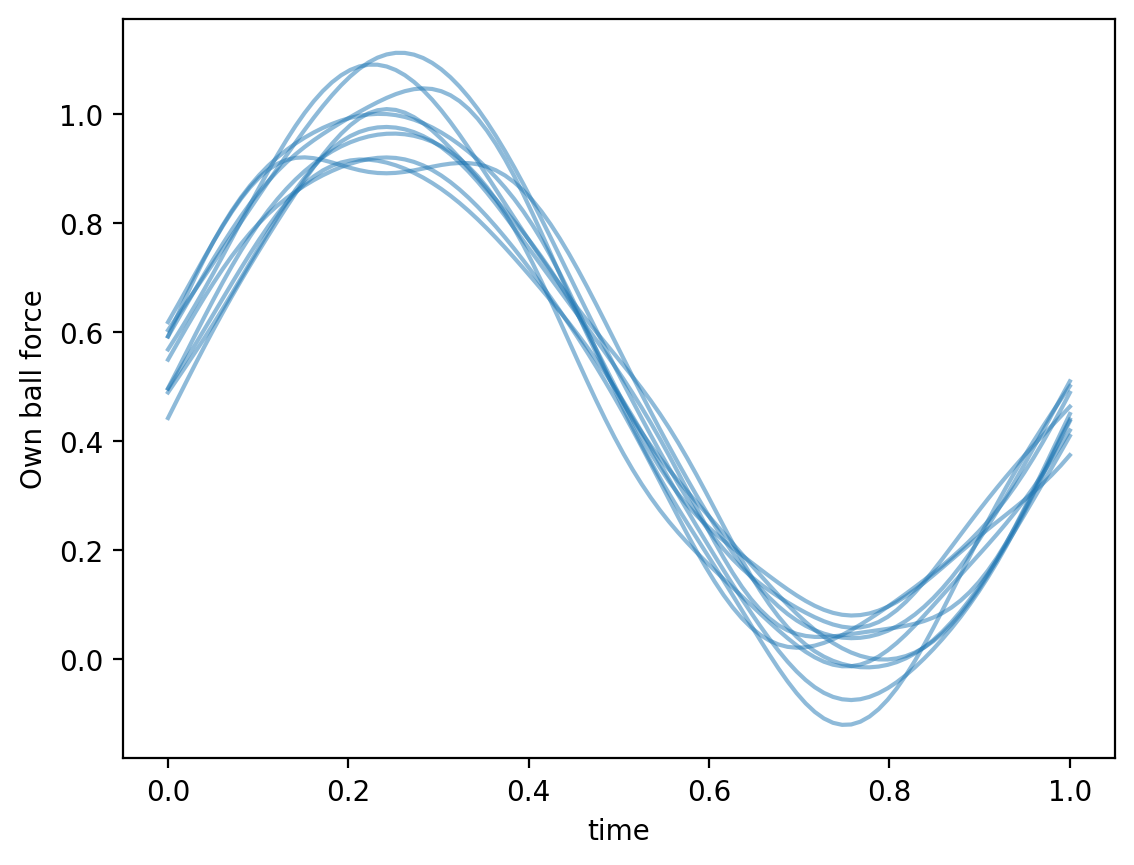

In [7]:
x = np.linspace(0, 1.0, 100)
mu = 0.5 + 0.5*np.cos(6*(x + 5))

alpha = 0.05
length = 0.1 

x2d = x.reshape((-1, 1))
sigma = alpha**2 * np.exp(-0.5 * cdist(x2d, x2d, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)

n_sample = 10
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Own ball force");

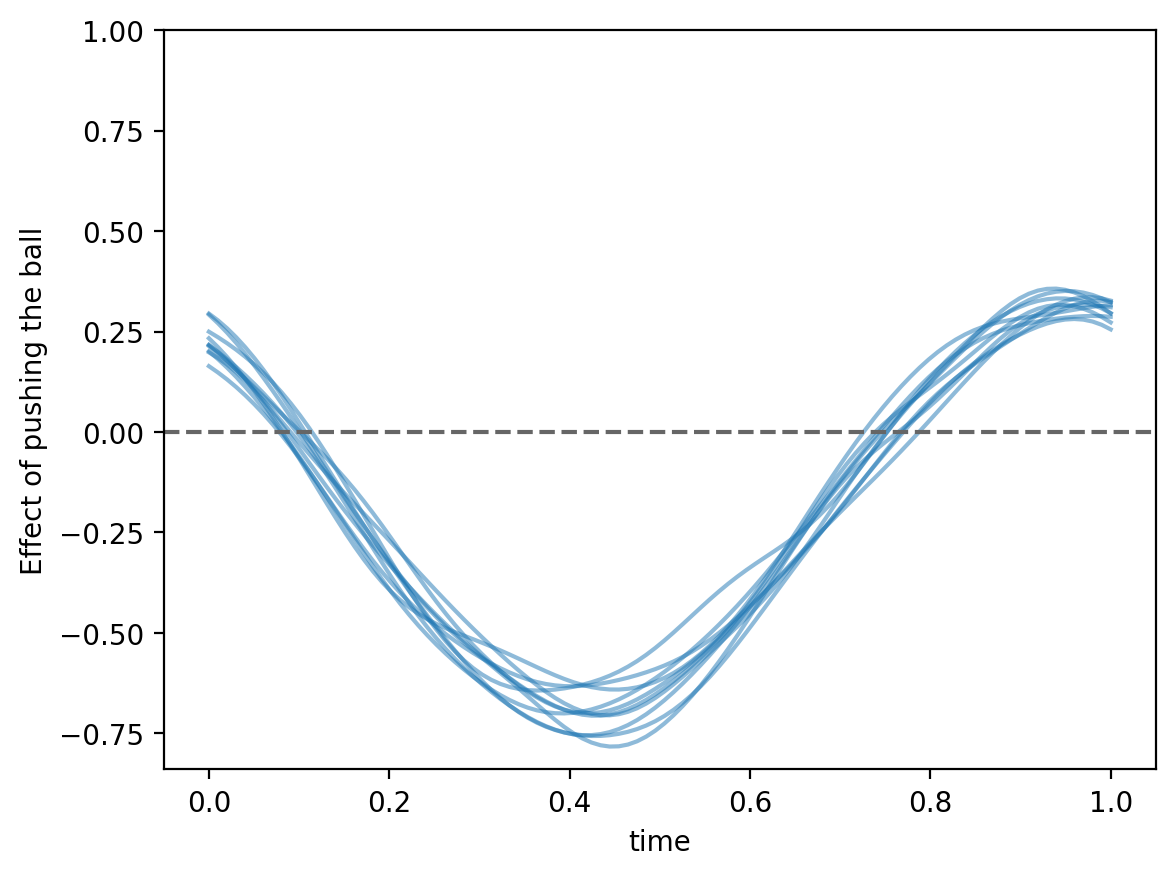

In [8]:
x = np.linspace(0, 1.0, 100).reshape((-1, 1))
mu = - 0.2 + 0.5*np.cos(6*(np.squeeze(x) - 2))

alpha = 0.05
length = 0.1

sigma = alpha**2 * np.exp(-0.5 * cdist(x, x, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Effect of pushing the ball")
ax.set_ylim(None, 1);
ax.axhline(y=0.0, ls="--", color="0.4");

In [22]:
class Ball:
    def __init__(self, n_step):
        
        self.state = np.zeros(2)
        
        self.n_step = n_step
        self.x = np.linspace(0, 1.0, self.n_step)
        
        self.min_position, self.max_position = 0.0, 200.0
        self.max_speed = 10.0 
        
        self.friction_factor = 0.5
        
        self.own_force = None
        self.action_effect = None
        self.current_step = None
    
    @staticmethod
    def square_exponential_kernel(x, alpha, length):
        return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)
    
    def sample_action_effect(self):
        
        x = self.x
        mu = - 0.2 + 0.5*np.cos(6*(x - 2))
        alpha = 0.05
        length = 0.1 
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)
    
    def sample_own_force(self):
        
        x = self.x
        alpha = 0.05
        length = 0.1 
        mu = 0.5 + 0.5*np.cos(6*(x + 5))
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)

    def step(self, action: int):

        position, velocity = self.state
        velocity -= self.friction_factor * velocity
        velocity += self.action_effect[self.current_step]*action
        velocity += self.own_force[self.current_step] 
        
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        
        self.state = position, velocity
        self.current_step += 1
        if self.current_step > self.n_step:
            raise ValueError("This wasn't supposed to be a step")
            
        return self.state
        
    def reset(self, seed=None):
                    
        if seed is not None:
            np.random.seed(seed)
            
        self.own_force = self.sample_own_force()
        self.action_effect = self.sample_action_effect()
        self.current_step = 0
        

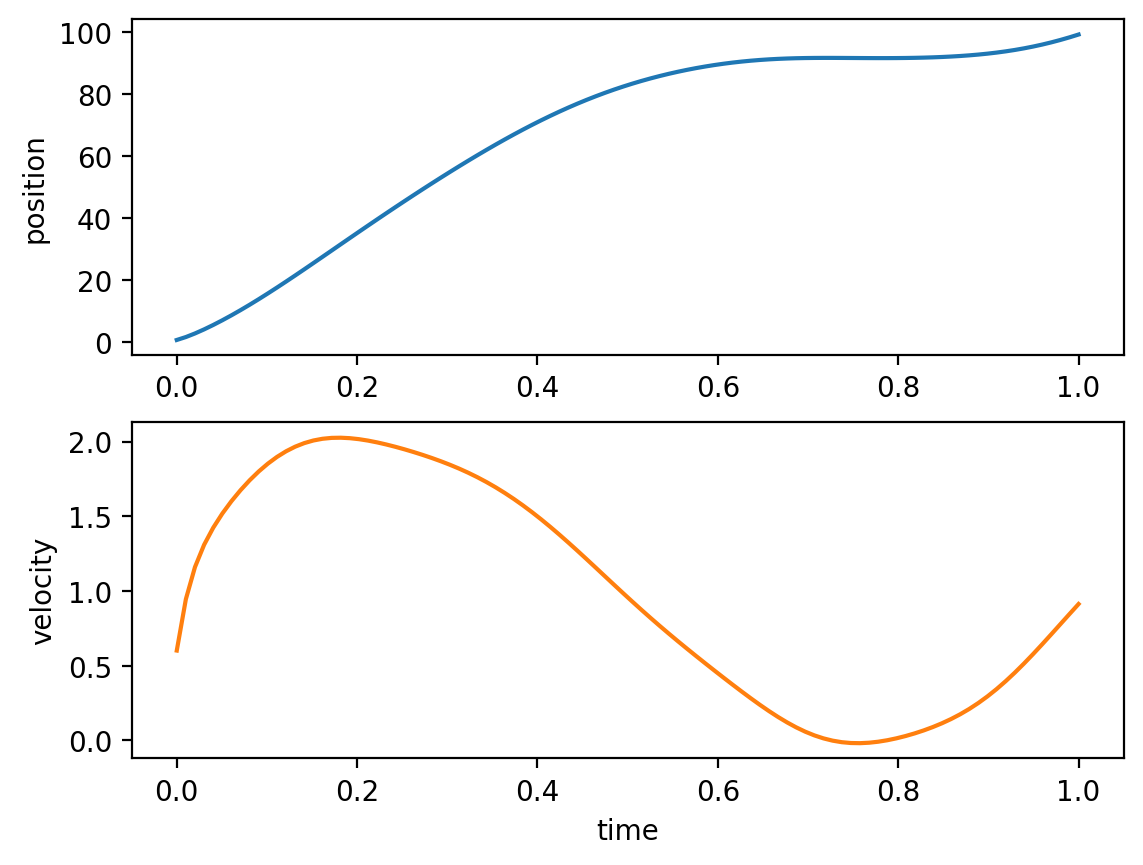

In [23]:
n_step = 100
ball = Ball(n_step)
ball.reset(seed=123456)
hist_pos, hist_vel = [], []
for i in range(n_step):
    pos, vel = ball.step(action=0)
    hist_pos.append(pos)
    hist_vel.append(vel)

fig, axes = plt.subplots(nrows=2)
x = np.linspace(0, 1, n_step)
axes[0].plot(x, hist_pos)
axes[0].set_ylabel("position")
axes[1].plot(x, hist_vel, color="C1")
axes[1].set_ylabel("velocity");
axes[1].set_xlabel("time");

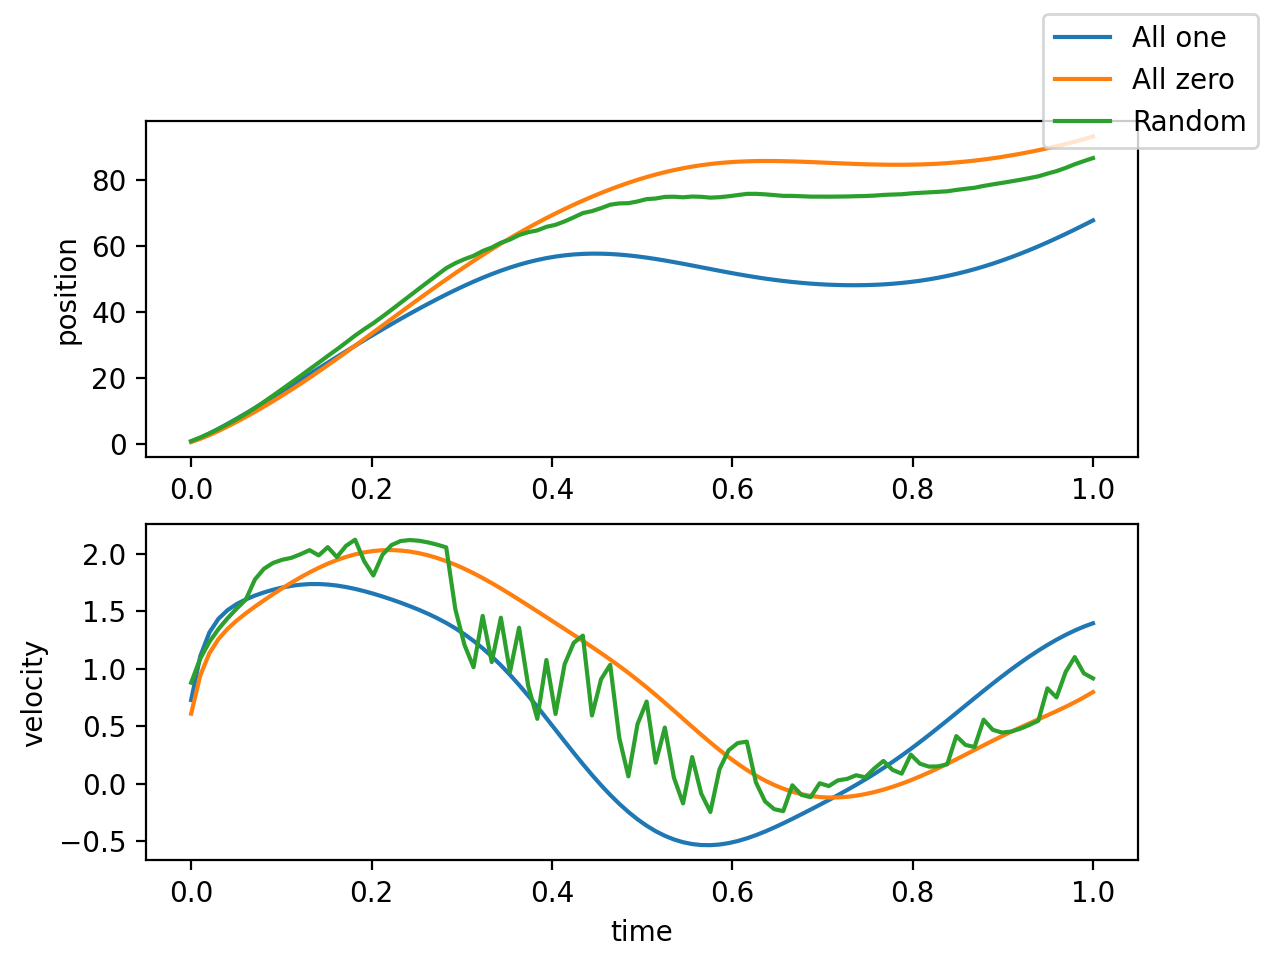

In [24]:
n_step = 100
all_hist_pos = []
all_hist_vel = []

policies = "all-one", "all-zero", "random"

for policy in policies:
    
    ball = Ball(n_step)
    ball.reset()
    hist_pos, hist_vel = [], []
    for i in range(n_step):
        if policy == "all-one":
            action = 1
        elif policy == "all-zero":
            action = 0
        elif policy == "random":
            action = np.random.choice([0, 1])
        else:
            raise ValueError
        pos, vel = ball.step(action=action)
        hist_pos.append(pos)
        hist_vel.append(vel)
        
    all_hist_pos.append(hist_pos)
    all_hist_vel.append(hist_vel)

fig, axes = plt.subplots(nrows=2)
for i in range(len(policies)):
    label = policies[i].replace("-", " ").capitalize()
    pos = all_hist_pos[i]
    vel = all_hist_vel[i]
    x = np.linspace(0, 1, n_step)
    axes[0].plot(x, pos, color=f"C{i}", label=label)
    axes[1].plot(x, vel, color=f"C{i}")
    axes[0].set_ylabel("position")
    axes[1].set_ylabel("velocity");
    axes[1].set_xlabel("time");
    
    
fig.legend();

# Title/abstract 

**Title**: Personalized nudging using active inference for improving adherence to an exercise plan

**Abstract**: Motivation is often a major obstacle to adherence to an exercise plan. For instance, poor adherence to rehabilitation programs has been observed, despite the importance they can have, notably in the treatment of cardiovascular conditions. In this work, we explore how nudging through personalized incentives (small monetary rewards spread over the day) can improve adherence to a daily exercise goal in participants. For personalizing the incentives, we are using the active inference framework that allows us to deal with the trade-off between learning about how the policy concerning the incentives affects the participant's behavior and helping them meet their objective.

# In general

"primitives":

$o$: observation

$s$: (hidden or partially observable) state. Some parts are potentially changing and other parts are potentially changing.

$a$: action

$\pi$: policy, that is what conditions the probability of an action $a$ and allows do define $p(a_t \mid \pi)$ 

$\tilde p(o)$: preferences (biased prior)

$p(s_{t+1} \mid s_t, a_t)$: transition probabilities. We will try to estimate that.

$p(o_t \mid s_t)$: generative model (produce observation $o$ conditionally to a state). We will try to estimate that too.

G: the expected free energy s.t.: 

$G = \sum_{t}^{T} \mathbb E_{q(o_t, s_t \mid \pi)} 
\left[\ln q(s_t \mid \pi) - \ln \tilde p(o_t, s_t) \right] 
= - \sum_{t}^{T}  \underbrace{ \mathbb E_{Q(o_t, s_t \mid \pi)} D_{KL}\left[ q(s_t \mid o_t, \pi) || q(s_t \mid \pi) \right] }_{ \text{epistemic value} } 
- \underbrace{ \mathbb E_{q(o_t \mid \pi) } \left[ \ln \tilde p(o_t) \right]}_{ \text{pragmatic value} } $

with:

$q(o_t, s_t \mid \pi) = p(o_{t} \mid s_t) q(s_t \mid \pi)$

$q(s_t \mid \pi) = p(s_t \mid s_{t-1},  a_{t-1}) p(a_{t-1} \mid \pi) q(s_{t-1} \mid \pi)$ with $q(s_{t_0} \mid \pi) = q(s_{t_0})$ (current belief over the state of the world)

$q(s_t \mid o_t, \pi) = p(o_t \mid s_t) q(s_t \mid \pi) / \int p(o_t \mid s_t) q(s_t \mid \pi)$

# In particular

## Adaptations to our context

Given our specific context, we assume that:
* $o_t$ is a reading of the step counter at XX:XX.

* $s_t$ is a bit of a catch-all for everything that (we think) will impact our reading of the step counter at XX:XX. Part of it is observable, part of it is latent. Contains both part of the context that the action has not effect on such at the time of the day, and part of the context on which the action has an impact such as the reward structure. 

* $p(s_{t+1} \mid s_t, a_t)$ is believed to be known and deterministic. Only part of $s$ is 'actionnable'. The action $a$ will affect the reward structure $r \subset s$.

* $p(o_t \mid s_t)$. We model it as a GP. More specifically, the GP has as input any relevant observable element of the context, and some encoding of the reward structure (what the action has an effect on), and as output a distribution over the possible readings.

* $\tilde p(o_t)$ $=>$ $\tilde p(s_t)$. Indeed, in our context, preferences are actually not about what is observed right now, but about what can be expected in a day/certain amount of time, information which is composed of previous meter readings and what can be predicted by evaluating the GP (*). More specifically, we assume that $\tilde p(s_t) = \mathbb{E}_{s_t \sim q(s_t)} p(S(s_t) \mid \mathcal{N}(\mathcal{O}, \sigma) )$ with $S(s_t)$ the number of expected step in one day given $s_t$, $\mathcal{O}$ the objective in terms of number of walking steps/distance traveled by the ball, and $sigma$ the tolerance. 

(*) that is why we probably want to have parameters of the GP inside $s$, and even the history of $o_t$.

## Open questions

* Does $s$ contains the hyper-parameters and the training dataset of the GP that models $p(o \mid s)$

In [3]:
# the hyper-parameters and the training dataset of the GP that defines the general level of activity of the user $b$ (see below)

In [19]:
transition_p = gp.GP()
ball_force = gp.GP()
# 1. Revise belief
# Add new data point
# Re-Train
# 2. Select action
# Simulate 
# Epistemic value/Info-gain: Compute KL div for both GPs?
# Pragmatic value: likelihood of the end position under the goal 

In [ ]:
# How to model effect that could come afterwards - like expectation of? One idea is to have all as one input of the GP
# Maybe that's already somewhat managed...